Importing necesary libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.validation import check_is_fitted
import pickle

Fetching historical data

In [2]:
def fetch_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    stock_data['Revenue'] = stock_data['Adj Close'] * stock_data['Volume']  # Approximation of revenue
    stock_data['Daily_Return'] = stock_data['Adj Close'].pct_change()  # Add daily returns
    stock_data['Moving_Avg_50'] = stock_data['Adj Close'].rolling(window=50).mean()  # 50-day Moving Average
    stock_data['Moving_Avg_200'] = stock_data['Adj Close'].rolling(window=200).mean()  # 200-day Moving Average
    stock_data['Adj_Close_Lag1'] = stock_data['Adj Close'].shift(1)  # Lagged adjusted close price (1 day)
    return stock_data


Cleaning data

In [3]:
def load_and_clean_data(stock_data):
    stock_data = stock_data.dropna()  # Remove NaN values
    stock_data['Date'] = pd.to_datetime(stock_data.index)
    stock_data['Year'] = stock_data['Date'].dt.year
    return stock_data


Data visualization

In [4]:
def generate_visualizations(stock_data):
    plt.figure(figsize=(10, 6))
    plt.plot(stock_data['Date'], stock_data['Adj Close'])
    plt.title('Adjusted Close Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.scatter(stock_data['Volume'], stock_data['Adj Close'])
    plt.title('Adjusted Close Price vs Volume')
    plt.xlabel('Volume')
    plt.ylabel('Adjusted Close Price')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.distplot(stock_data['Adj Close'], bins=30, kde=True)
    plt.title('Distribution of Adjusted Close Price')
    plt.show()

    plt.figure(figsize=(10, 6))
    corr_matrix = stock_data[['Adj Close', 'Volume', 'Revenue', 'Daily_Return', 'Moving_Avg_50', 'Moving_Avg_200', 'Adj_Close_Lag1']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()


Preparing the data for modeling

In [5]:
def prepare_data(stock_data):
    features = stock_data[['Revenue', 'Volume', 'Daily_Return', 'Moving_Avg_50', 'Moving_Avg_200', 'Adj_Close_Lag1']]
    target = stock_data['Adj Close']

    # Optionally, you can add polynomial features
    poly = PolynomialFeatures(degree=2, include_bias=False)
    features_poly = poly.fit_transform(features)

    return features_poly, target


Splitting Data into Training and Testing sets

In [6]:
def split_data(features, target):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)
    return X_train, X_test, y_train, y_test


Standardizing the data

In [7]:
def standardize_data(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled


Training and building the model

In [8]:
def build_and_train_model(X_train, y_train, model_type='linear'):
    if model_type == 'ridge':
        LR = Ridge()
    elif model_type == 'lasso':
        LR = Lasso()
    else:
        LR = LinearRegression()

    # Fit the model to the training data
    LR.fit(X_train, y_train)

    return LR


Predictions

In [9]:
def predict_prices(LR, X_test):
    try:
        # Check if the model is fitted
        check_is_fitted(LR)
        print("Model is fitted and ready for predictions.")
    except Exception as e:
        print("Model is not fitted.")
        raise e

    predictions = LR.predict(X_test)
    return predictions




Assessing the model

In [10]:
def assess_model(y_test, predictions):
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)

    print(f"R-squared: {r2}")
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")


Main function

[*********************100%%**********************]  1 of 1 completed
<ipython-input-3-8bb2d349abb6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['Date'] = pd.to_datetime(stock_data.index)
<ipython-input-3-8bb2d349abb6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['Year'] = stock_data['Date'].dt.year


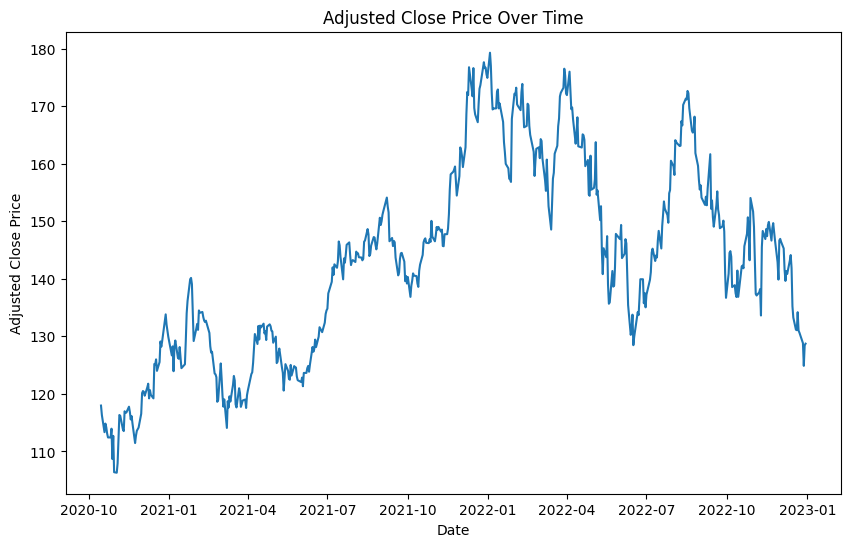

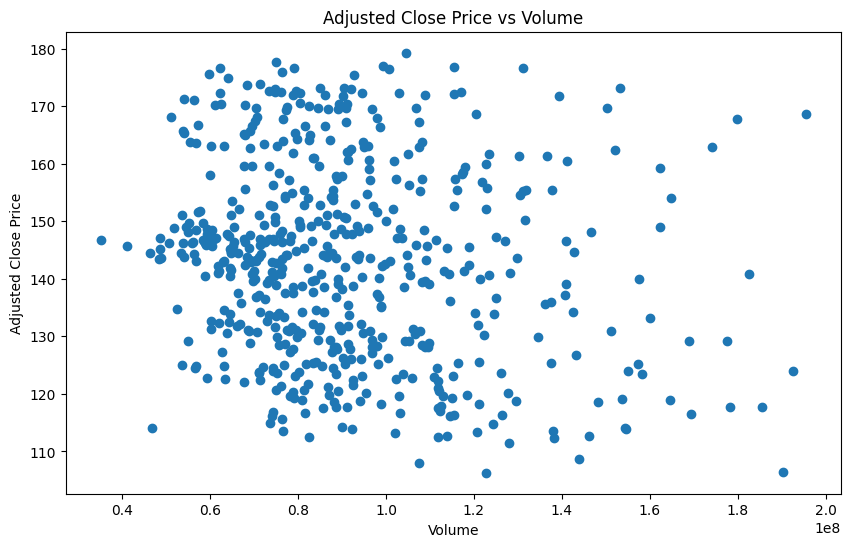

<ipython-input-4-67f283cbfc8a>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(stock_data['Adj Close'], bins=30, kde=True)


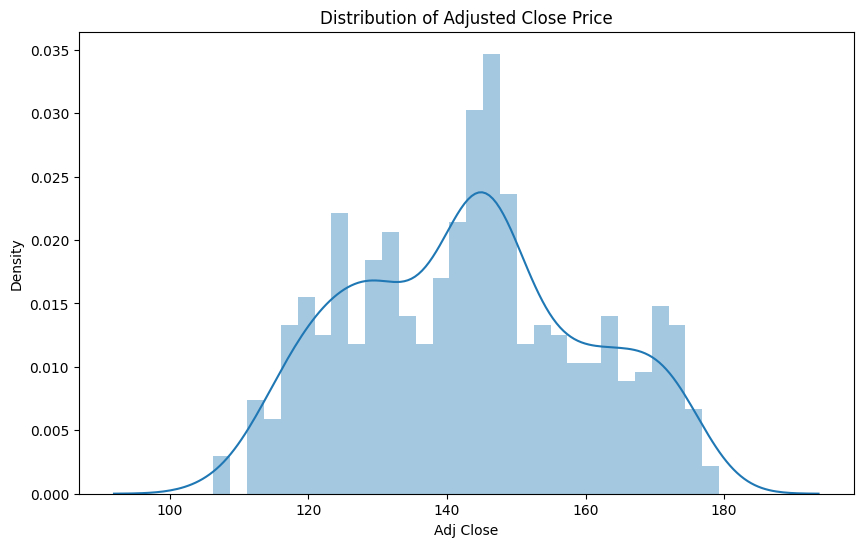

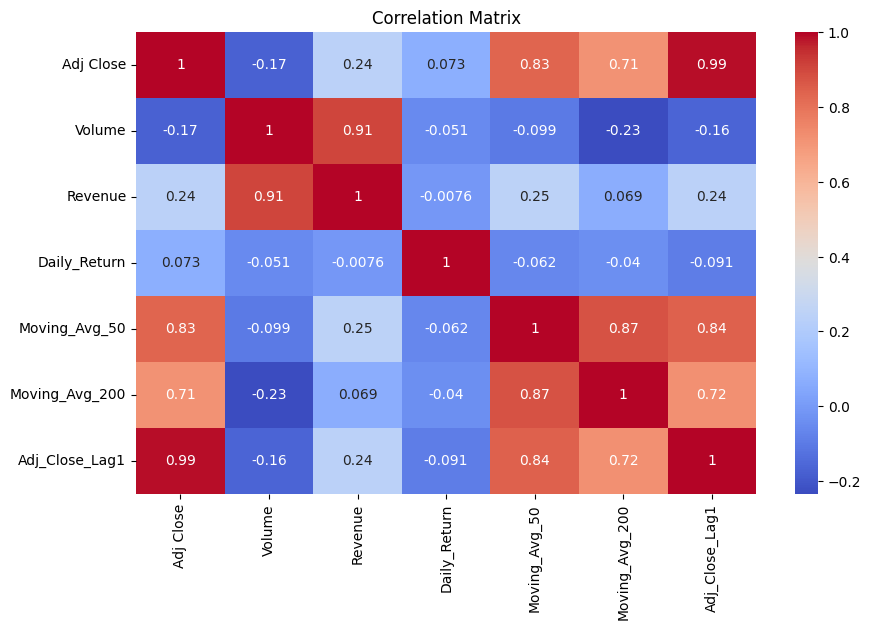

Model is fitted and ready for predictions.
R-squared: 1.0
Mean Absolute Error: 4.314009467114894e-14
Mean Squared Error: 3.1085627442309127e-27
Root Mean Squared Error: 5.575448631483311e-14


In [11]:
def main():
    ticker = 'AAPL'  # You can change this to any ticker symbol
    start_date = '2020-01-01'
    end_date = '2023-01-01'

    # Step 1: Fetch the data
    stock_data = fetch_data(ticker, start_date, end_date)

    # Step 2: Load and clean the data
    stock_data_cleaned = load_and_clean_data(stock_data)

    # Step 3: Generate data visualizations
    generate_visualizations(stock_data_cleaned)

    # Step 4: Prepare the data
    features, target = prepare_data(stock_data_cleaned)

    # Step 5: Split the data into training and test sets (70:30)
    X_train, X_test, y_train, y_test = split_data(features, target)

    # Step 6: Perform standardization (if necessary)
    X_train_scaled, X_test_scaled = standardize_data(X_train, X_test)

    # Step 7: Fit the model to your training data
    LR = build_and_train_model(X_train_scaled, y_train, model_type='linear')

    # Step 8: Make predictions using your test data (X_test)
    predictions = predict_prices(LR, X_test_scaled)

    # Step 9: Assess your model
    assess_model(y_test, predictions)

    # Step 10: Save the fitted model to a file
    with open('linear_regression_model.pkl', 'wb') as file:
        pickle.dump(LR, file)

if __name__ == "__main__":
    main()
